# K-Means Clustering — Scikit-Learn

First unsupervised model in the project. K-Means groups data into K clusters by iteratively refining centroids — no labels used during training. We evaluate using inertia (WCSS), silhouette score, and ARI (comparing clusters to ground truth bean types).

**Dataset**: Dry Beans — 13,543 samples, 16 geometric features, 7 bean types.


In [1]:
import sys
import os
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score as sklearn_silhouette

# Add project root to path for utils
sys.path.insert(0, os.path.abspath('../..'))
from utils.data_loader import load_processed_data
from utils.performance import track_performance
from utils.visualization import (plot_elbow_curve, plot_silhouette_comparison,
                                  plot_silhouette_analysis, plot_convergence_curve)
from utils.results import save_results, add_result, print_comparison
from utils.metrics import adjusted_rand_index

# Configuration
RANDOM_STATE = 113
K_RANGE = range(2, 13)       # Test K=2 through K=12
MAX_ITER = 300
TOL = 1e-4
N_INIT = 5                   # 5 random initializations, keep best by inertia
FRAMEWORK = 'Scikit-Learn'

# Load preprocessed data
X_train, X_test, y_train, y_test, meta = load_processed_data('kmeans')

print("=" * 60)
print(f"K-MEANS — {FRAMEWORK}")
print("=" * 60)
print(f"Training: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test:     {X_test.shape[0]:,} samples")
print(f"Classes:  {meta['n_classes']} ({meta['class_names']})")

K-MEANS — Scikit-Learn
Training: 10,834 samples, 16 features
Test:     2,709 samples
Classes:  7 (['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])


In [2]:
# Step 1: K-Tuning - finding optimal number of clusters
# Run K-Means for each k, track inertia (elbow method) and silhouette (cluster quality)
print("=" * 60)
print("K-TUNING: Testing K=2 through K=12")
print("=" * 60)

inertias = []
sil_scores = []
k_list = list(K_RANGE)

for k in k_list:
    model = KMeans(
        n_clusters=k,
        init='k-means++',
        n_init=N_INIT,
        max_iter=MAX_ITER,
        tol=TOL,
        random_state=RANDOM_STATE
    )
    model.fit(X_train)

    inertias.append(model.inertia_)

    # sklearn's silhouette_score for speed during tuning loop
    sil = sklearn_silhouette(X_train, model.labels_)
    sil_scores.append(sil)

    print(f"    K={k:2d} | Inertia: {model.inertia_:,.1f} | Silhouette: {sil:.4f}")

print(f"\nTuning complete.")

K-TUNING: Testing K=2 through K=12
    K= 2 | Inertia: 103,635.7 | Silhouette: 0.3965
    K= 3 | Inertia: 75,557.9 | Silhouette: 0.4034
    K= 4 | Inertia: 60,743.3 | Silhouette: 0.3428
    K= 5 | Inertia: 49,175.7 | Silhouette: 0.3583
    K= 6 | Inertia: 43,871.6 | Silhouette: 0.3610
    K= 7 | Inertia: 38,925.7 | Silhouette: 0.3083
    K= 8 | Inertia: 36,050.3 | Silhouette: 0.3026
    K= 9 | Inertia: 33,511.6 | Silhouette: 0.3029
    K=10 | Inertia: 31,718.2 | Silhouette: 0.2902
    K=11 | Inertia: 30,243.4 | Silhouette: 0.2865
    K=12 | Inertia: 29,278.6 | Silhouette: 0.2654

Tuning complete.


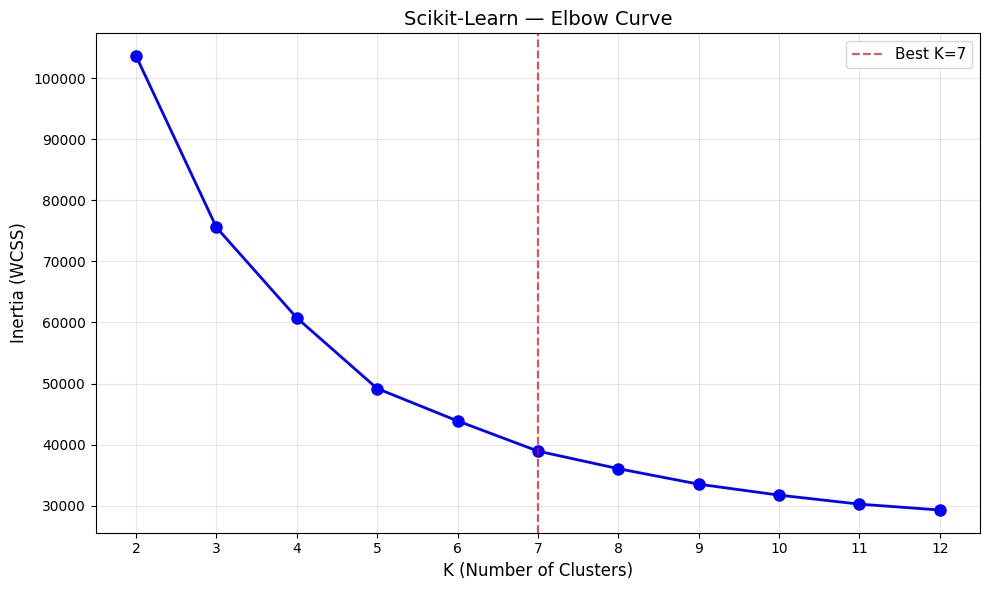

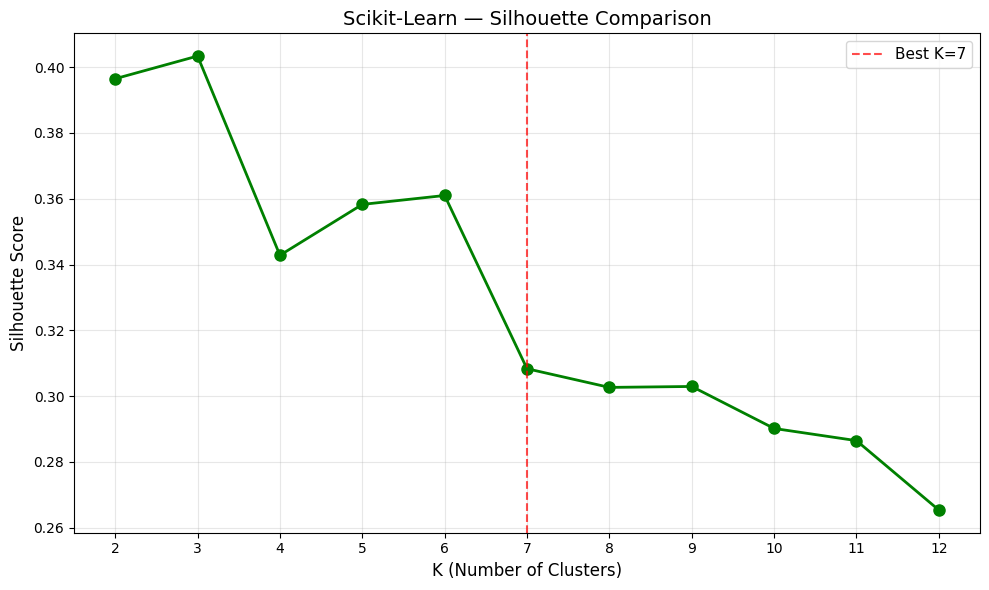

Geometric optimum:  K=3 (Silhouette: 0.4034)
Ground truth match: K=7 (Silhouette: 0.3083)
Selected: K=7 — matches actual bean class count for ARI evaluation


In [3]:
# Step 2: Visualize K-tuning results
"""
Two complementary views of the k-tuning results:
    - Elbow: Looks for where inertia stops dropping sharply
    - Silhouette: peaks at the K with best-defined cluster boundaries
Both suggest K=3 as the geometric optimum, but we use K=7
to match the actual number of bean classes for ARI evaluation.
"""

plot_elbow_curve(k_list, inertias, FRAMEWORK, best_k=7)
plot_silhouette_comparison(k_list, sil_scores, FRAMEWORK, best_k=7)

print(f"Geometric optimum:  K=3 (Silhouette: {sil_scores[1]:.4f})")
print(f"Ground truth match: K=7 (Silhouette: {sil_scores[5]:.4f})")
print(f"Selected: K=7 — matches actual bean class count for ARI evaluation")

In [ ]:
# Step 3: Train final K-Means model (K=7)
"""
K=7 chosen to match the 7 actual bean types - enables ARI evaluation.
K-Means++ initialization biases first centroids to be spread apart,
reducing sensitivity to random starting positions.
"""

with track_performance(gpu=False) as perf:
    final_model = KMeans(
        n_clusters=7,
        init='k-means++',
        n_init=N_INIT,
        max_iter=MAX_ITER,
        tol=TOL,
        random_state=RANDOM_STATE
    )
    final_model.fit(X_train)

print("=" * 60)
print("FINAL MODEL TRAINED (K=7)")
print("=" * 60)
print(f"Iterations:    {final_model.n_iter_}")
print(f"Inertia:       {final_model.inertia_:,.2f}")
print(f"Training time: {perf['time']:.4f}s")
print(f"Peak memory:   {perf['memory']:.2f} MB")

FINAL MODEL TRAINED (K=7)
Iterations:    26
Inertia:       38,925.66
Training time: 0.0614s
Peak memory:   2.71 MB


In [6]:
# Step 4: Assign test samples to nearest centroids
"""
K-Means "prediction" = find closest centroid for each sample.
No retraining - centroids are fixed from step 3 onwards.
"""

train_labels = final_model.labels_
test_labels = final_model.predict(X_test)

print("=" * 60)
print("TEST SET CLUSTER ASSIGNMENTS")
print("=" * 60)
print(f"Train clusters: {np.unique(train_labels)}")
print(f"Test clusters:  {np.unique(test_labels)}")
print(f"Train samples per cluster:")
for c in range(7):
    count = np.sum(train_labels == c)
    print(f"    Cluster {c}: {count:,} ({count/len(train_labels)*100:.1f}%)")

TEST SET CLUSTER ASSIGNMENTS
Train clusters: [0 1 2 3 4 5 6]
Test clusters:  [0 1 2 3 4 5 6]
Train samples per cluster:
    Cluster 0: 2,509 (23.2%)
    Cluster 1: 2,494 (23.0%)
    Cluster 2: 447 (4.1%)
    Cluster 3: 416 (3.8%)
    Cluster 4: 1,632 (15.1%)
    Cluster 5: 1,374 (12.7%)
    Cluster 6: 1,962 (18.1%)


In [7]:
# Step 5: Evaluate clustering quality
"""
Three complementary metrics:
    - Inertia: compactness (lower = tighter clusters)
    - Silhouette: separation vs cohesion (-1 to +1, higher = better)
    - ARI: agreement with ground truth labels (-0.5 to 1.0, higher = better)
"""
from utils.metrics import inertia, silhouette_score

train_inertia = inertia(X_train, train_labels, final_model.cluster_centers_)
test_inertia = inertia(X_test, test_labels, final_model.cluster_centers_)

train_sil = silhouette_score(X_train, train_labels)
test_sil = silhouette_score(X_test, test_labels)

train_ari = adjusted_rand_index(y_train, train_labels)
test_ari = adjusted_rand_index(y_test, test_labels)

print("=" * 60)
print("EVALUATION METRICS")
print("=" * 60)
print(f"{'Metric':<20} {'Train':>10} {'Test':>10}")
print("-" * 40)
print(f"{'Inertia':<20} {train_inertia:>10,.2f} {test_inertia:>10,.2f}")
print(f"{'Silhouette':<20} {train_sil:>10.4f} {test_sil:>10.4f}")
print(f"{'ARI':<20} {train_ari:>10.4f} {test_ari:>10.4f}")

EVALUATION METRICS
Metric                    Train       Test
----------------------------------------
Inertia               38,925.66   9,981.06
Silhouette               0.3083     0.3061
ARI                      0.6655     0.6686


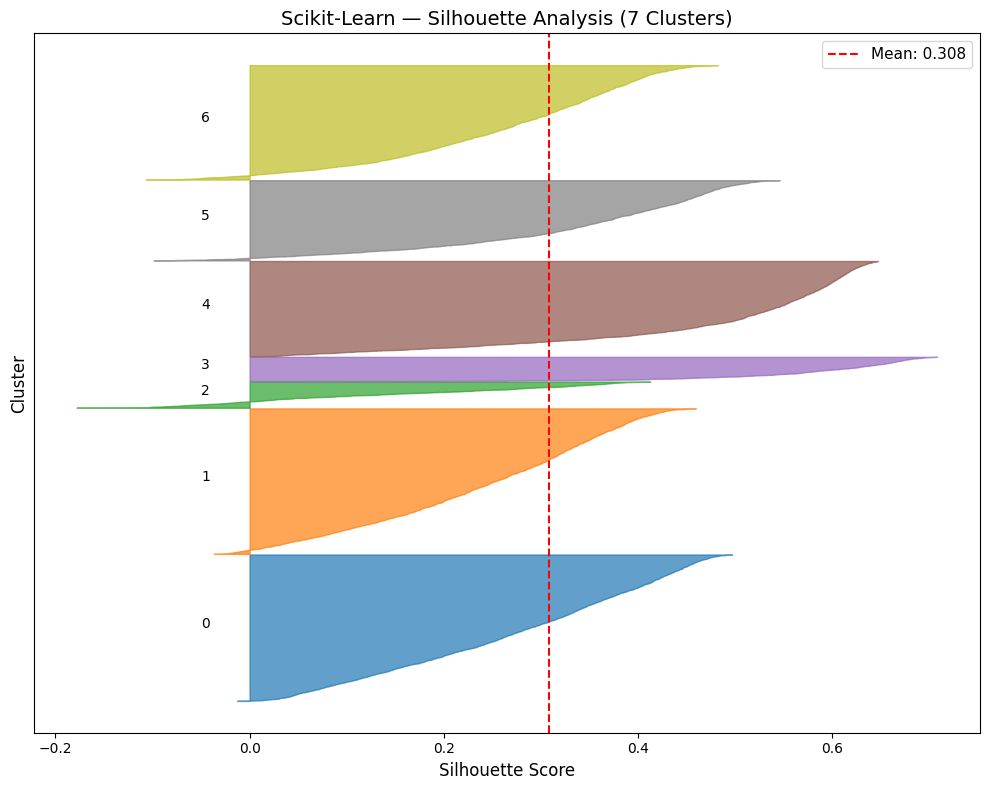

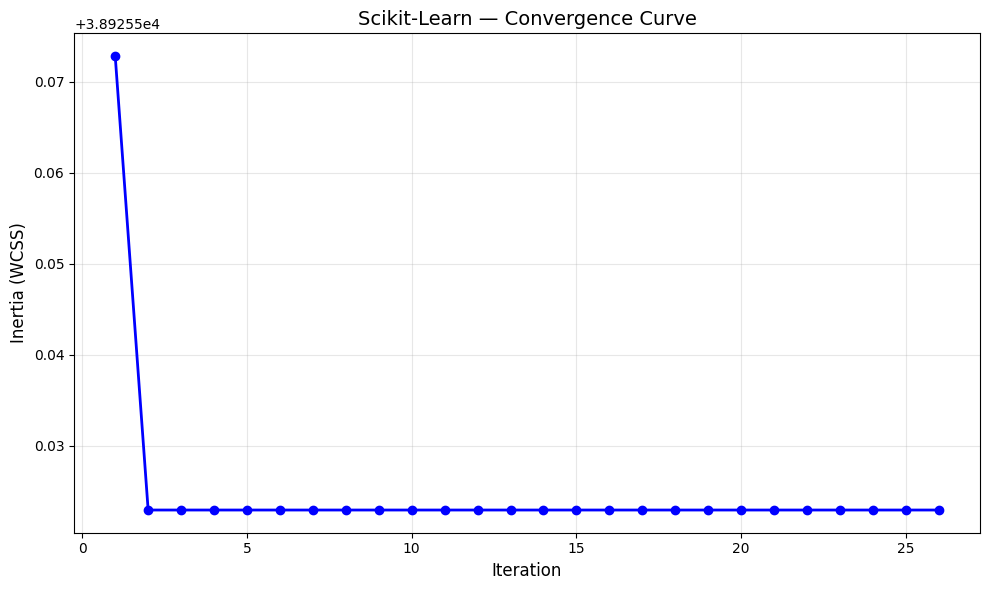

Silhouette analysis and convergence plotted.
Convergence: 26 iterations tracked


In [9]:
# Step 6: Visualizations - silhouette analysis + convergence
"""
Silhouette analysis: per-sample blade plot reveals which clusters
are well-defined vs overlapping. More insightful than 2d scatter
for 16-dimensional data.
"""

plot_silhouette_analysis(X_train, train_labels, FRAMEWORK)

"""
Convergence curve: extract per-iteration inertia by re-running
with max_iter=1 in a loop, passing previous centroids forward.
"""
inertia_history = []
centroids = final_model.cluster_centers_.copy()

for i in range(final_model.n_iter_):
    step_model = KMeans(
        n_clusters=7,
        init=centroids,
        n_init=1,
        max_iter=1,
        random_state=RANDOM_STATE
    )
    step_model.fit(X_train)
    inertia_history.append(step_model.inertia_)
    centroids = step_model.cluster_centers_

plot_convergence_curve(inertia_history, FRAMEWORK)

print(f"Silhouette analysis and convergence plotted.")
print(f"Convergence: {len(inertia_history)} iterations tracked")

In [10]:
# Step 7: MiniBatchKMeans comparison (sklearn-specific)
"""
Minibatchkmeans processes random mini-batches instead of full data.
Typically much faster with similar quality - showcases sklearn's
built-in optimization that other frameworks don't offer
"""

with track_performance(gpu=False) as mini_perf:
    mini_model = MiniBatchKMeans(
        n_clusters=7,
        init='k-means++',
        n_init=N_INIT,
        batch_size=1024,
        max_iter=MAX_ITER,
        tol=TOL,
        random_state=RANDOM_STATE
    )
    mini_model.fit(X_train)

mini_labels = mini_model.predict(X_test)
mini_sil = sklearn_silhouette(X_test, mini_labels)
mini_ari = adjusted_rand_index(y_test, mini_labels)

print("=" * 60)
print("MINIBATCHKMEANS vs STANDARD KMEANS")
print("=" * 60)
print(f"{'Metric':<20} {'KMeans':>12} {'MiniBatch':>12}")
print("-" * 44)
print(f"{'Inertia':<20} {final_model.inertia_:>12,.2f} {mini_model.inertia_:>12,.2f}")
print(f"{'Test Silhouette':<20} {test_sil:>12.4f} {mini_sil:>12.4f}")
print(f"{'Test ARI':<20} {test_ari:>12.4f} {mini_ari:>12.4f}")
print(f"{'Training Time':<20} {perf['time']:>11.4f}s {mini_perf['time']:>11.4f}s")
print(f"{'Peak Memory':<20} {perf['memory']:>10.2f} MB {mini_perf['memory']:>10.2f} MB")

MINIBATCHKMEANS vs STANDARD KMEANS
Metric                     KMeans    MiniBatch
--------------------------------------------
Inertia                 38,925.66    44,921.94
Test Silhouette            0.3061       0.2596
Test ARI                   0.6686       0.5691
Training Time             0.0614s      0.1338s
Peak Memory                2.71 MB       1.39 MB
